In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# 探討：
* 四種出場條件下的獲利情況
* 因為沒資料而出場的要另外考量

In [123]:
trade_result = pd.read_csv('trade_result_finance_ASR_3_Num_30_ADF_2.5.csv')
trade_result['date_in'] = trade_result['date_in'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['date_out'] = trade_result['date_out'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['stock_1_profit'] = None
trade_result['stock_2_profit'] = None
trade_result['net_profit'] = None
trade_result.head()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
0,"(2809, 2812)",-2.709090,-2.056534,3.336841,4.090072,1.286543,0.535449,2000-11-13,2000-12-04,1.157086,...,1.147402,1.050822,2.86,3.58,1.275363,1.316408,3.73,None,None,None
1,"(2816, 2845)",-2.615544,NaN,4.078891,NaN,1.176371,NaN,2000-12-04,2000-12-11,0.788119,...,4.311604,NaN,78.27,2.21,0.792993,NaN,2.30,None,None,None
2,"(2812, 2816)",-4.066761,NaN,4.096069,NaN,9.108208,NaN,2000-12-11,2000-12-18,1.236138,...,1.226712,NaN,3.39,78.27,4.360164,NaN,98.89,None,None,None
3,"(2816, 2834)",-3.012278,-2.052855,3.725501,4.098245,1.961577,0.532206,2000-12-18,2000-12-26,0.415200,...,4.594008,4.450503,85.67,9.69,2.271094,2.158715,8.66,None,None,None
4,"(2823, 2836)",-2.572162,NaN,4.528659,NaN,1.115157,NaN,2001-01-02,2001-01-08,0.712323,...,0.879627,NaN,2.55,4.09,1.408545,NaN,4.49,None,None,None


In [124]:
trade_result.groupby('reason').count()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
reason,,,,,,,,,,,,,,,,,,,,,
cointegration_invalid,440,440,0,440,0,440,0,440,440,440,...,440,0,440,440,440,0,440,0,0,0
reversion,124,124,124,124,124,124,124,124,124,124,...,124,124,124,124,124,124,124,0,0,0
stop_loss,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,0,0,0
take_profit,151,151,151,151,151,151,151,151,151,151,...,151,151,151,151,151,151,151,0,0,0


In [125]:
cost_rate = 0.001425*0.6
tax_rate = 0.003

In [126]:
def calculate_profit(x):
    if x['spread_in'] > 0:
        # buy stock_1, short stock_2
        stock_1_profit = (
            x['stock_1_out'] - x['stock_1_in'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_in'] - x['stock_2_out'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000
    else:
        # short stock_1, buy stock_2
        stock_1_profit = (
            x['stock_1_in'] - x['stock_1_out'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_out'] - x['stock_2_in'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000

    total_profit = stock_1_profit + stock_2_profit
    
    return [stock_1_profit, stock_2_profit, total_profit]

In [127]:
trade_result = trade_result.copy()
for i in range(len(trade_result)):
    temp_result = trade_result.iloc[i]
    trade_result.loc[i, ['stock_1_profit', 'stock_2_profit', 'net_profit']] = calculate_profit(temp_result)

In [128]:
trade_result.reason.unique()

array(['stop_loss', 'cointegration_invalid', 'reversion', 'take_profit'], dtype=object)

In [129]:
def plot_equity_curve(select_result = None, figsize=(16, 8)):
    if select_result == None:
        temp_result = trade_result
        title = 'total result'
    else: 
        temp_result = trade_result[trade_result.reason.isin(select_result)]
        title = str(select_result)
    accumulate_profit = temp_result.net_profit.values.cumsum()

    # 找出創新高的index(要畫綠點)
    new_highest_index = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
        if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
            new_highest = current_accumulate_profit
            new_highest_index.append(i)

    # 找出drawdown
    drawdown = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
            drawdown.append(0)
        else:
            if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
                new_highest = current_accumulate_profit 
            if (current_accumulate_profit < new_highest):
                drawdown.append(current_accumulate_profit-new_highest)
            else:
                drawdown.append(0)
    
    print('   Net profit:   ', accumulate_profit[-1])
    print('   MDD:          ', min(drawdown))
    print('   Calmar ratio: ', accumulate_profit[-1]/abs(min(drawdown)))
    

    plt.style.use('seaborn')
    plt.figure(figsize=figsize)
    # 權益曲線
    plt.plot(accumulate_profit, c='black')
    # 創新高的點
    plt.scatter(new_highest_index,
                accumulate_profit[new_highest_index], c='#02ff0f', s=70)
#     plt.plot(drawdown, c='red')
    plt.title('Equity Curve - {}'.format(title), size=20)
    plt.xlabel('Trade Number', size=15)
    plt.ylabel('NTD', size=15)
    plt.xticks(size=13)
    plt.yticks(size=13);

   Net profit:    25091.2252154
   MDD:           -36737.277581
   Calmar ratio:  0.682990871059


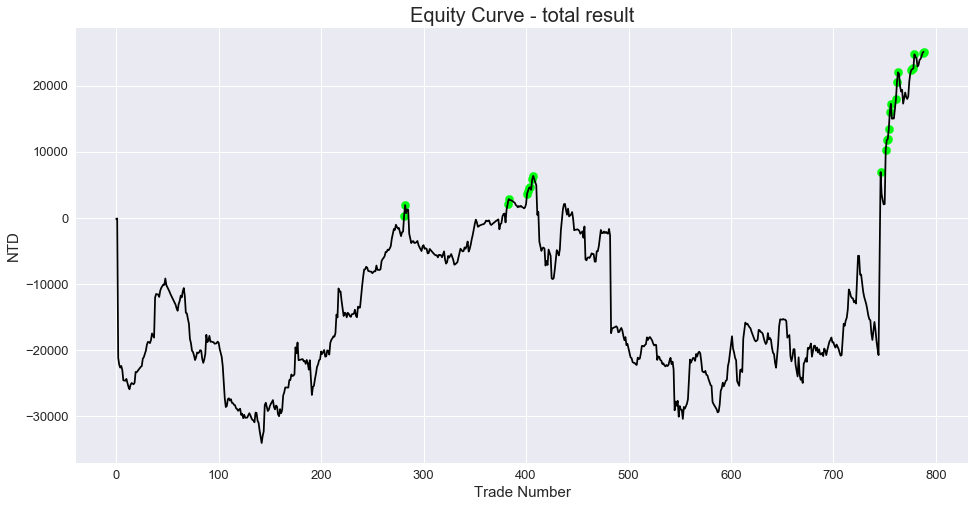

In [130]:
plot_equity_curve(None)

   Net profit:    65082.3964378
   MDD:           -4488.18099264
   Calmar ratio:  14.5008404395


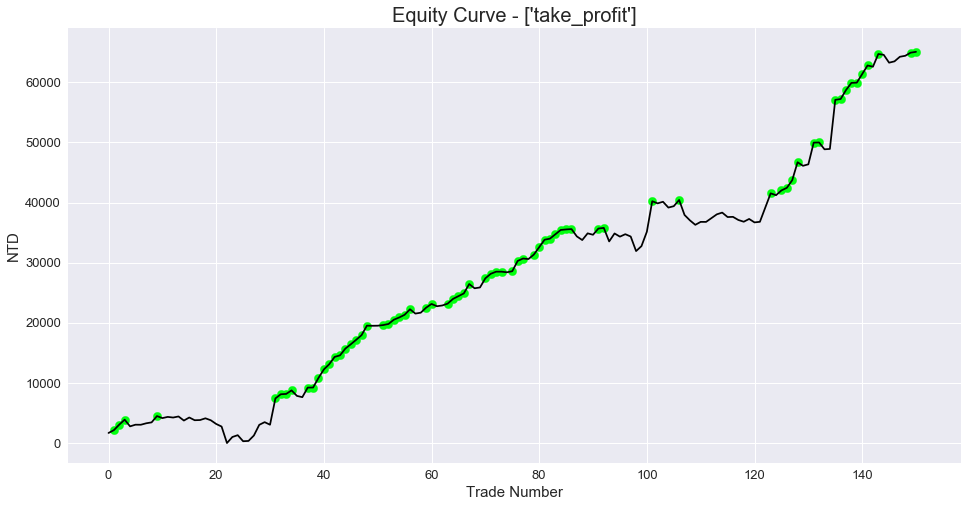

In [131]:
plot_equity_curve(['take_profit'])

   Net profit:    93172.637701
   MDD:           -4003.9677536
   Calmar ratio:  23.2700769424


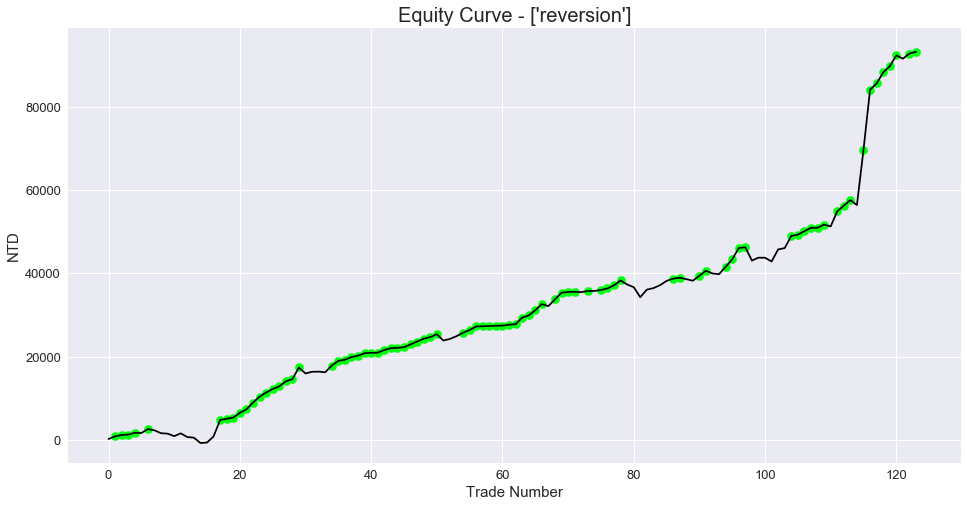

In [132]:
plot_equity_curve(['reversion'])

   Net profit:    -17350.1611451
   MDD:           -17182.3696665
   Calmar ratio:  -1.00976532817


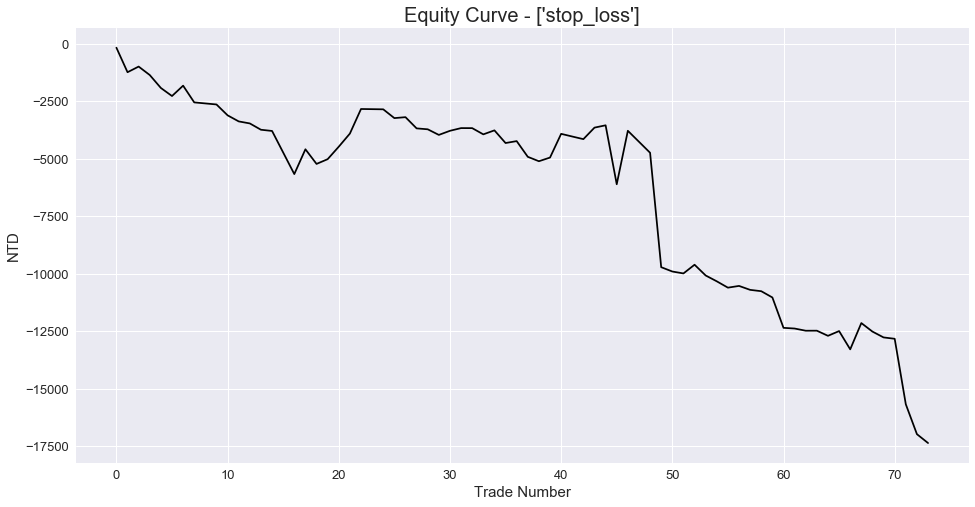

In [133]:
plot_equity_curve(['stop_loss'])

   Net profit:    -115813.647778
   MDD:           -119980.309866
   Calmar ratio:  -0.965272117629


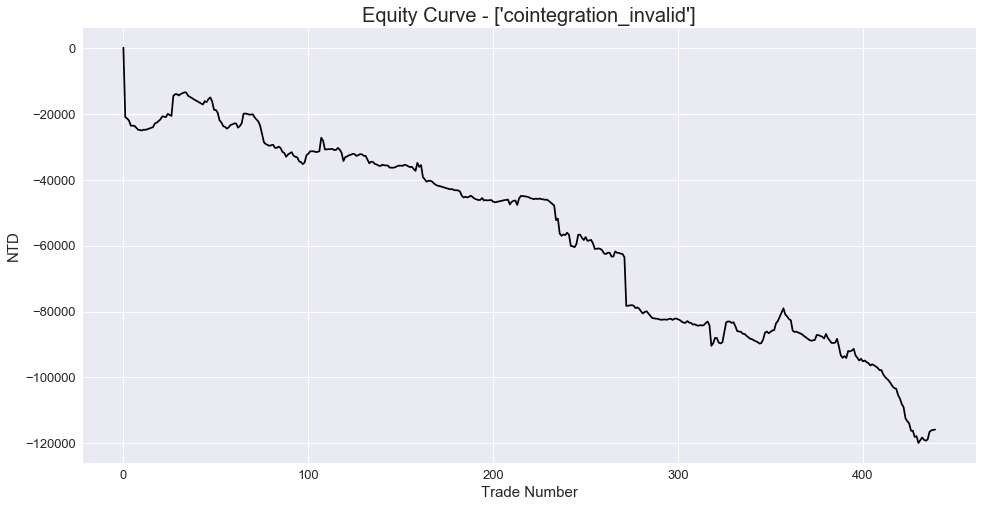

In [134]:
plot_equity_curve(['cointegration_invalid'])

In [135]:
win_loss_ratio = np.mean(trade_result[trade_result.net_profit > 0].net_profit) / np.mean(trade_result[trade_result.net_profit < 0].net_profit)
winning_rate = len(trade_result[trade_result.net_profit > 0]) / len(trade_result)
print('   Winning rate: ', winning_rate)
print('   Expection:   ', abs(win_loss_ratio)*winning_rate - (1-winning_rate))

   Winning rate:  0.49809885931558934
   Expection:    0.0436079503729


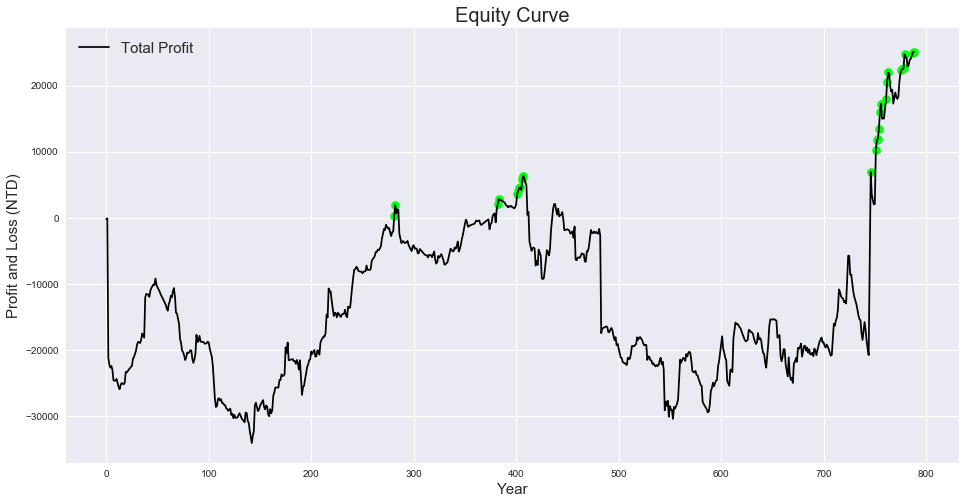

In [137]:
plt.figure(figsize=(16, 8))
accumulate_profit = trade_result.net_profit.values.cumsum()

# 找出創新高的index(要畫綠點)
new_highest_index = []
for i in range(len(accumulate_profit)):
    current_accumulate_profit = accumulate_profit[i]
    if i == 0:
        new_highest = accumulate_profit[i]
    if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
        new_highest = current_accumulate_profit
        new_highest_index.append(i)

# 權益曲線
plt.plot(accumulate_profit, c='black', label='Total Profit')
# 創新高的點
plt.scatter(new_highest_index,
            accumulate_profit[new_highest_index], c='#02ff0f', s=70)

plt.legend(fontsize=15)
plt.title('Equity Curve', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Profit and Loss (NTD)', fontsize=15);

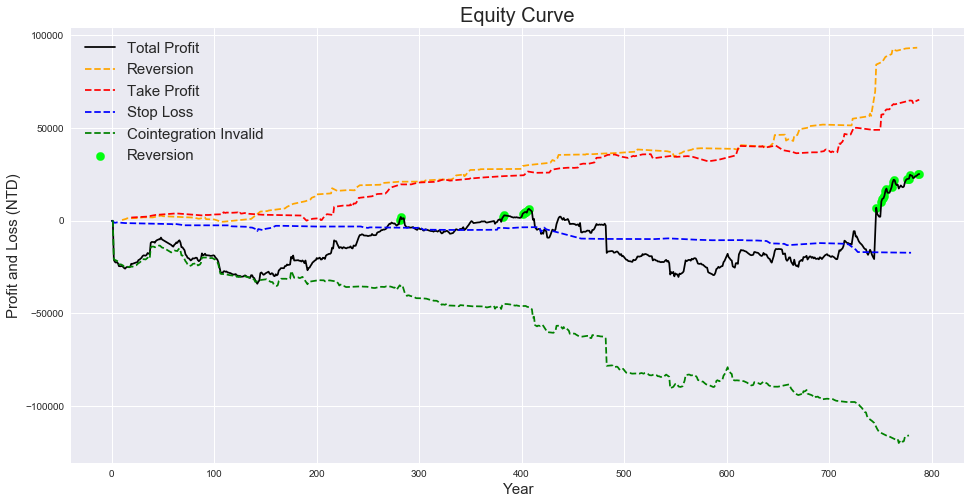

In [138]:
plt.figure(figsize=(16, 8))
accumulate_profit = trade_result.net_profit.values.cumsum()

# 找出創新高的index(要畫綠點)
new_highest_index = []
for i in range(len(accumulate_profit)):
    current_accumulate_profit = accumulate_profit[i]
    if i == 0:
        new_highest = accumulate_profit[i]
    if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
        new_highest = current_accumulate_profit
        new_highest_index.append(i)

# 權益曲線
plt.plot(accumulate_profit, c='black', label='Total Profit')
# 創新高的點
plt.scatter(new_highest_index,
            accumulate_profit[new_highest_index], c='#02ff0f', s=70,
            label='Reversion')

plt.plot(trade_result[trade_result.reason == 'reversion']['net_profit'].cumsum(),
         c='orange', ls='--', label='Reversion')
plt.plot(trade_result[trade_result.reason == 'take_profit']['net_profit'].cumsum(),
         c='red', ls='--', label='Take Profit')
plt.plot(trade_result[trade_result.reason == 'stop_loss']['net_profit'].cumsum(),
         c='blue', ls='--', label='Stop Loss')
plt.plot(trade_result[trade_result.reason == 'cointegration_invalid']['net_profit'].cumsum(),
         c='green', ls='--', label='Cointegration Invalid')

plt.legend(fontsize=15)
plt.title('Equity Curve', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Profit and Loss (NTD)', fontsize=15);

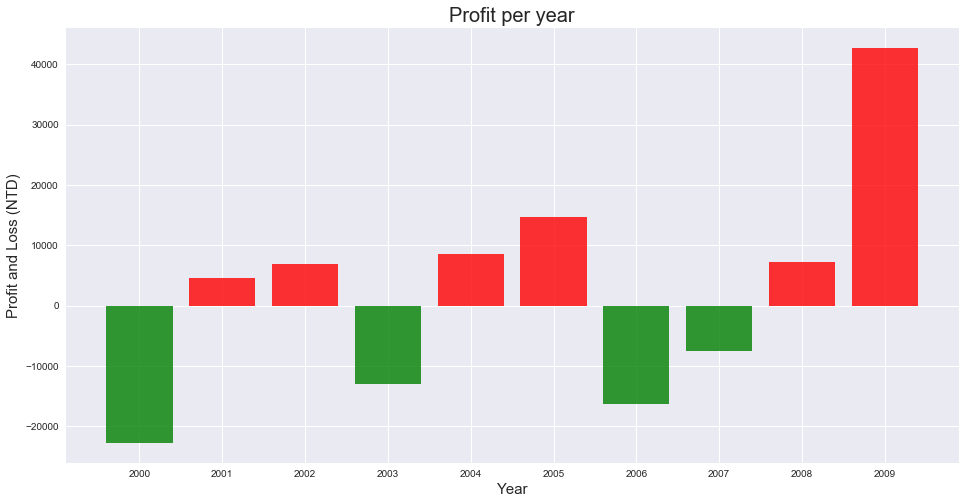

In [136]:
plt.figure(figsize=(16, 8))
trade_result['month'] = trade_result.date_in.apply(lambda x: x.month)
trade_result['year'] = trade_result.date_in.apply(lambda x: x.year)
temp = trade_result.groupby(['year'])['net_profit'].sum()

gain = temp[temp > 0]
loss = temp[temp <= 0]

plt.figure(figsize=(16, 8))
plt.bar(gain.index, gain, color='red', alpha=0.8)
plt.bar(loss.index, loss, color='green', alpha=0.8)
plt.xticks(list(map(lambda x: int(x), temp.index)))
plt.title('Profit per year', fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Profit and Loss (NTD)', fontsize=15);